## Loading packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
import tensorflow as tf
from sklearn.metrics import classification_report

2024-10-10 17:54:38.643196: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 17:54:38.679040: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 17:54:38.688511: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-10 17:54:38.710255: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-10 17:54:40.670154: W tensorflow/compiler/tf2

## Loading data

In [2]:
data_path = 'dataset/magic/magic.csv'

df = pd.read_csv(data_path)
df.head()

,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.011,-8.2027,40.092,81.8828,g
0,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.261,g
1,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.788,g
2,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.737,g
3,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.462,g
4,51.6240,21.1502,2.9085,0.2420,0.1340,50.8761,43.1887,9.8145,3.6130,238.098,g


## The shape

In [3]:
df.shape 

(19019, 11)

## label the data

In [4]:
cols = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConcl' ,'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class']
df = pd.read_csv(data_path, names=cols)
df.head()

,fLength,fWidth,fSize,fConc,fConcl,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


### Check the output in column Class

In [5]:
df['class'].unique()

array(['g', 'h'], dtype=object)

## Convert class to integers
- g --> 1
- h --> 0

In [6]:
df['class'] = (df['class'] == 'g').astype(int)
df.head()

,fLength,fWidth,fSize,fConc,fConcl,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,1
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,1
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,1
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,1
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,1


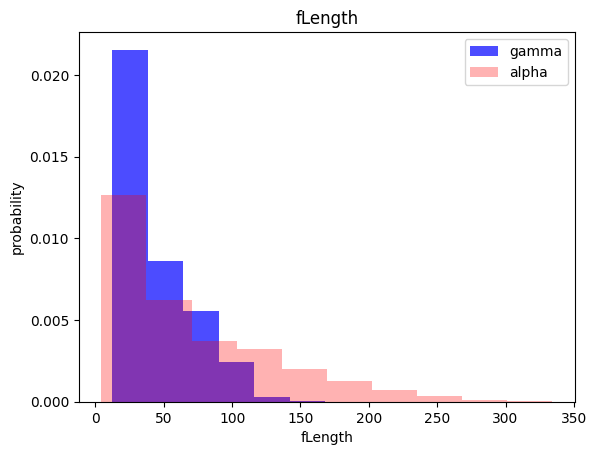

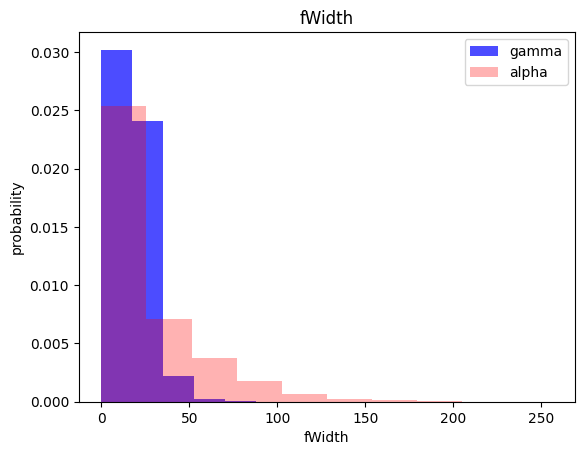

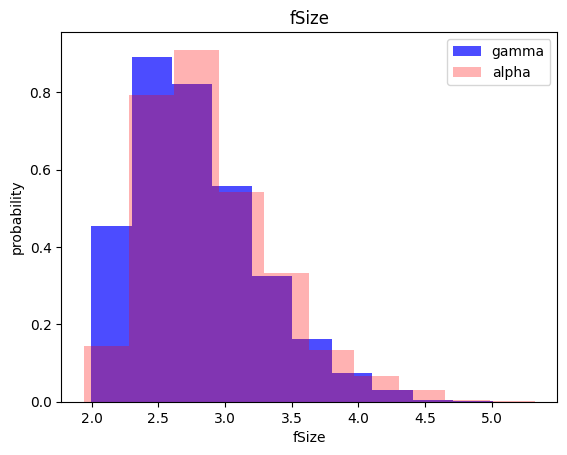

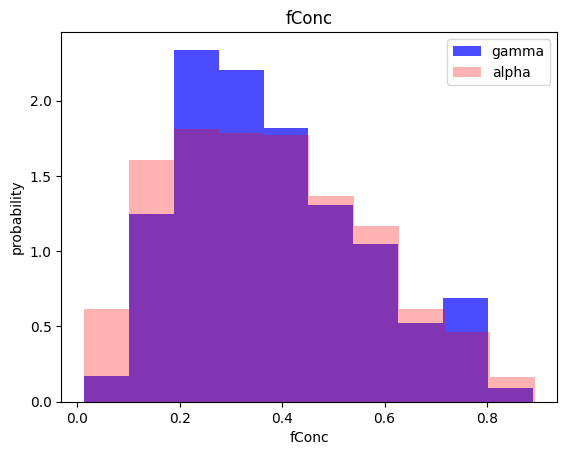

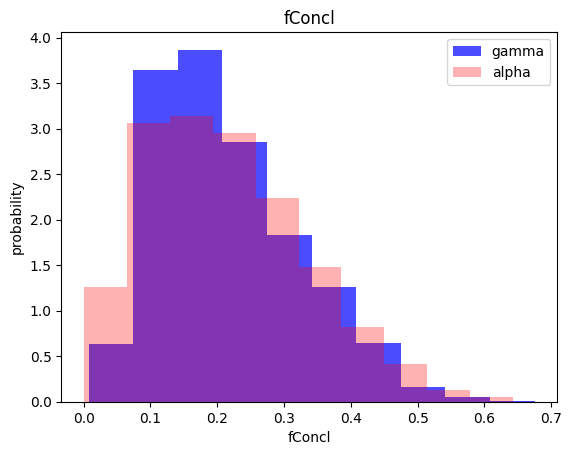

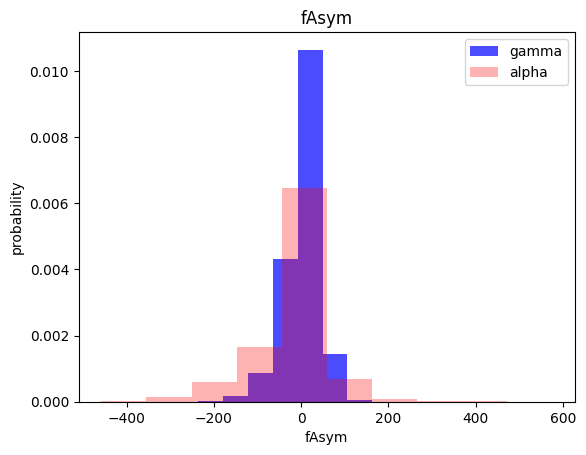

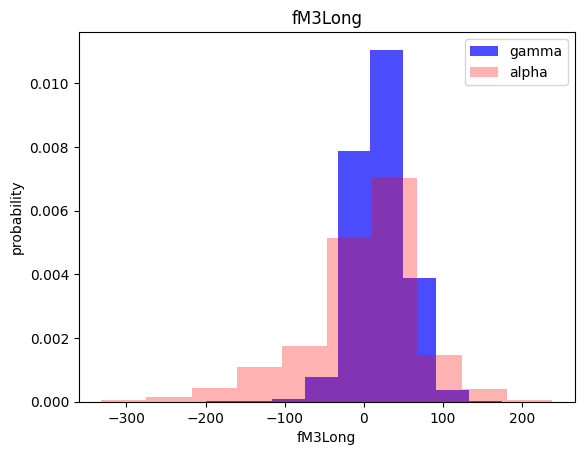

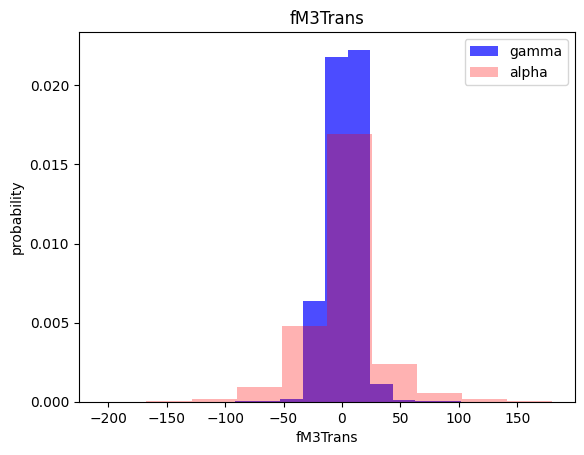

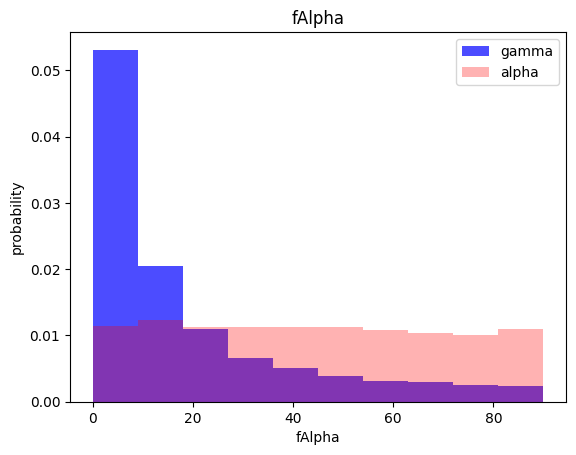

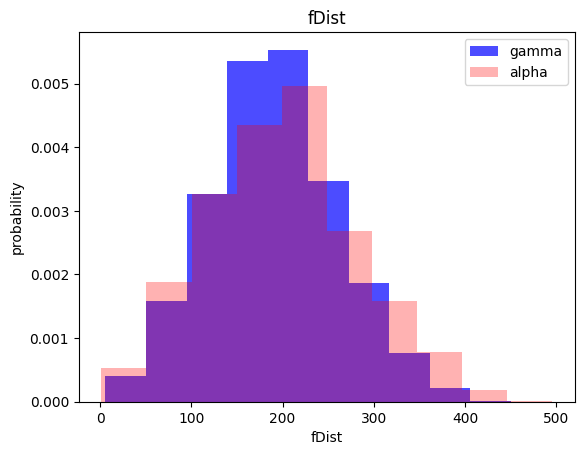

In [7]:
for label in cols[:-1]:
    plt.hist(df[df['class']==1][label], color='blue', label='gamma', alpha=0.7, density=True)
    plt.hist(df[df['class']==0][label], color='red', label='alpha', alpha=0.3, density=True)
    plt.title(label)
    plt.ylabel('probability')
    plt.xlabel(label)
    plt.legend()
    plt.show()

## Train validate and test data

In [8]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

/home/vx/allenv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


## Scale up data to be in one range

In [9]:
def scale_dataset(data, oversample=False):
    if isinstance(data, np.ndarray):
        X = data[:, :-1]
        y = data[:, -1]
    elif isinstance(data, pd.DataFrame):
        X = data[data.columns[:-1]].values
        y = data[data.columns[-1]].values
    else:
        raise ValueError("Input data must be a Pandas DataFrame or a NumPy array.")
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    if oversample:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X, y)
        
    # join columns
    scaled_data = np.hstack((X, np.reshape(y, (-1, 1))))
    
    return scaled_data, X, y

## checking the length of train data for 

In [10]:
print(len(train[train['class']==1]))
print(len(train[train['class']==0]))

7395
4017


## oversample to match the number of samples

In [11]:
train, X_train, y_train = scale_dataset(train, oversample=True)

In [12]:
print(len(train[y_train==1]))
print(len(train[y_train==0]))

7395
7395


In [13]:
train, X_train, y_train = scale_dataset(train, oversample=True)
valid, X_valid, y_valid = scale_dataset(valid, oversample=False)
test, X_test, y_test = scale_dataset(test, oversample=False)

## Neural networks

In [14]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_oss')
    plt.title('loss model')
    plt.ylabel('loss')
    plt.xlabel('enpoch')
    plt.legend()
    plt.show()


def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Accurarcy model')
    plt.ylabel('Accuracy')
    plt.xlabel('enpoch')
    plt.legend()
    plt.show()



In [15]:
nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(10,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])

print(nn_model.summary())

/home/vx/allenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,441 (5.63 KB)

 Trainable params: 1,441 (5.63 KB)

 Non-trainable params: 0 (0.00 B)

None


In [16]:
# Train the model
history_1 = nn_model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.3)

Epoch 1/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6843 - loss: 0.6364 - val_accuracy: 0.3998 - val_loss: 0.7332
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7498 - loss: 0.5426 - val_accuracy: 0.5339 - val_loss: 0.6832
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7847 - loss: 0.4808 - val_accuracy: 0.6090 - val_loss: 0.6523
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7862 - loss: 0.4581 - val_accuracy: 0.6453 - val_loss: 0.6269
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8074 - loss: 0.4275 - val_accuracy: 0.6522 - val_loss: 0.6184
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8225 - loss: 0.4001 - val_accuracy: 0.6694 - val_loss: 0.5983
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8151 - loss: 0.4044 - val_accuracy: 0.6883 - val_loss: 0.5733
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8297 - loss: 0.3912 - val_accu

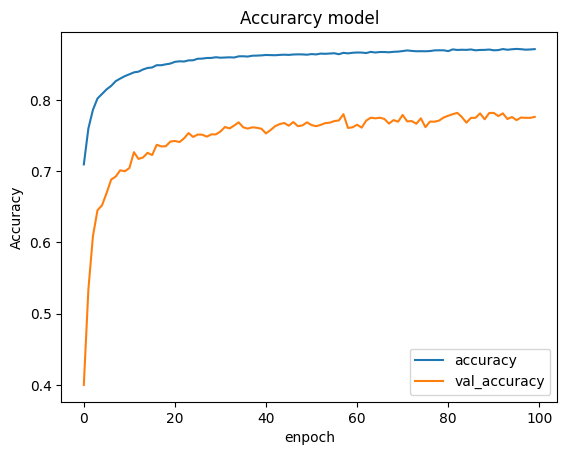

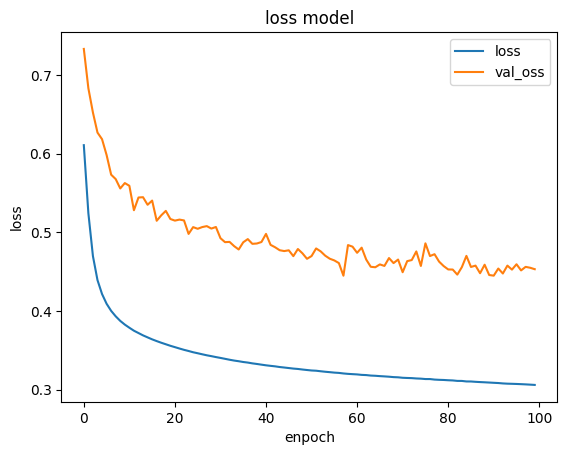

In [17]:
plot_accuracy(history_1)
plot_loss(history_1)

### Accuracy

In [18]:
y_pred = nn_model.predict(X_test)
y_pred = (y_pred>0.5).astype(int).reshape(-1,1)

print(classification_report(y_test, y_pred))

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      1301
           1       0.89      0.89      0.89      2503

    accuracy                           0.85      3804
   macro avg       0.83      0.83      0.83      3804
weighted avg       0.85      0.85      0.85      3804



## NN Model2

In [19]:
nn_model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(10,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


nn_model_2.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])

print(nn_model_2.summary())

/home/vx/allenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,817 (11.00 KB)

 Trainable params: 2,817 (11.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [20]:
# Train the model
history_2 = nn_model_2.fit(X_train, y_train, batch_size=64, epochs=100, validation_split=0.3)

Epoch 1/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6217 - loss: 0.6684 - val_accuracy: 0.3279 - val_loss: 0.7345
Epoch 2/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7279 - loss: 0.6006 - val_accuracy: 0.4575 - val_loss: 0.7120
Epoch 3/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7764 - loss: 0.5405 - val_accuracy: 0.5436 - val_loss: 0.6803
Epoch 4/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7882 - loss: 0.4949 - val_accuracy: 0.6024 - val_loss: 0.6522
Epoch 5/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7979 - loss: 0.4603 - val_accuracy: 0.6306 - val_loss: 0.6348
Epoch 6/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8056 - loss: 0.4388 - val_accuracy: 0.6516 - val_loss: 0.6184
Epoch 7/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8132 - loss: 0.4253 - val_accuracy: 0.6646 - val_loss: 0.6047
Epoch 8/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8186 - loss: 0.4119 - val_accu

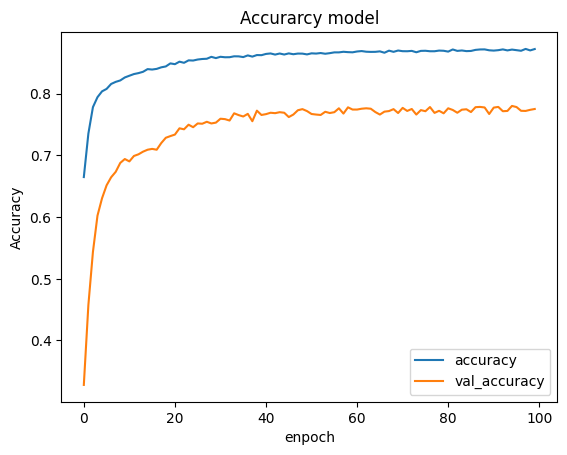

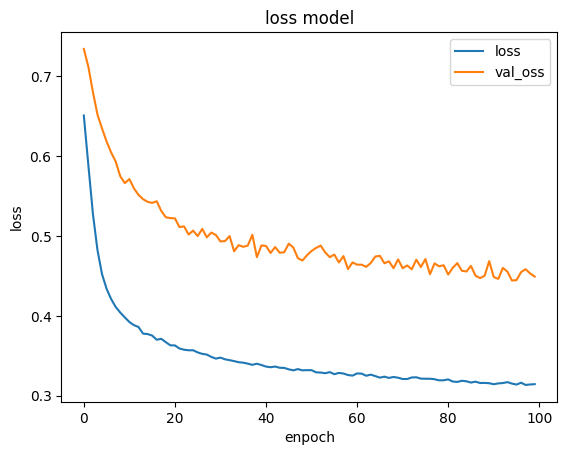

In [21]:
plot_accuracy(history_2)
plot_loss(history_2)

### Accuracy

In [22]:
y_pred = nn_model_2.predict(X_test)
y_pred = (y_pred>0.5).astype(int).reshape(-1,1)

print(classification_report(y_test, y_pred))

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      1301
           1       0.89      0.89      0.89      2503

    accuracy                           0.85      3804
   macro avg       0.83      0.83      0.83      3804
weighted avg       0.85      0.85      0.85      3804



## NN model 3

In [23]:
def train_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs):
    nn_model = tf.keras.Sequential([
        tf.keras.layers.Dense(num_nodes, activation='relu', input_shape=(10,)),
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(num_nodes, activation='relu'),
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])
    
    history = nn_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=0)
    
    return nn_model, history

In [24]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_oss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('enpoch')
    ax2.grid(True)
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='accuracy')
    ax2.plot(history.history['val_accuracy'], label='val_accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('epochs')
    ax2.grid(True)

    plt.show()



nodes: 16 dropout: 0 lr: 0.1 batch size 32


/home/vx/allenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


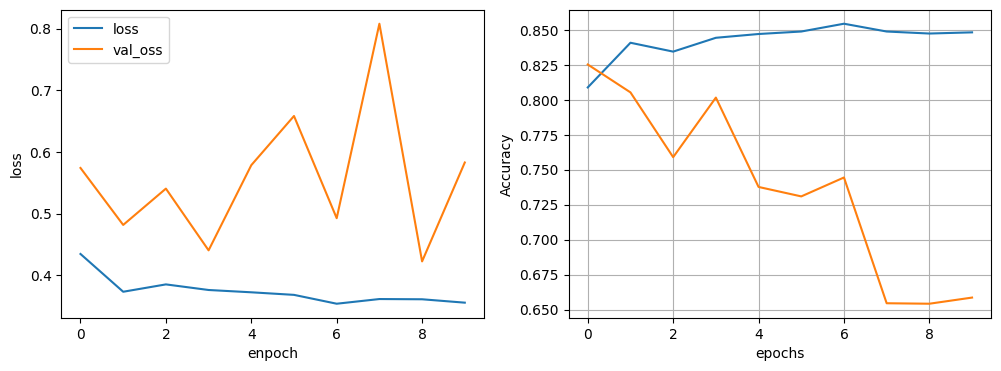

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - accuracy: 0.8394 - loss: 0.3685
nodes: 16 dropout: 0 lr: 0.1 batch size 64


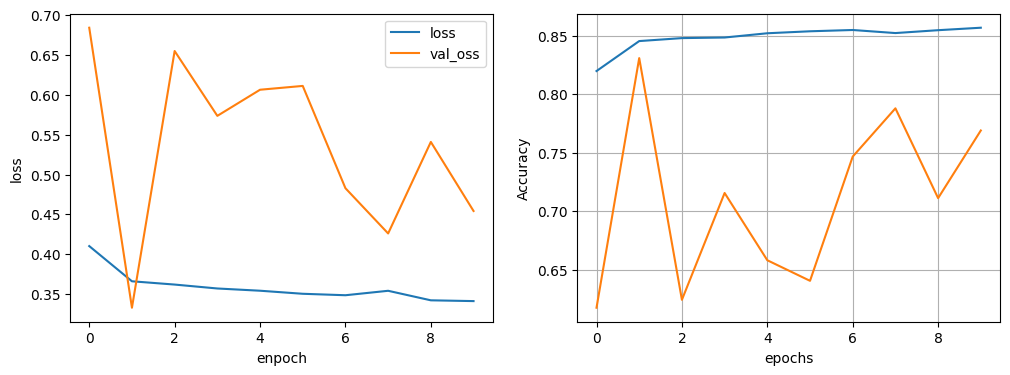

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - accuracy: 0.8486 - loss: 0.3776
nodes: 16 dropout: 0 lr: 0.1 batch size 128


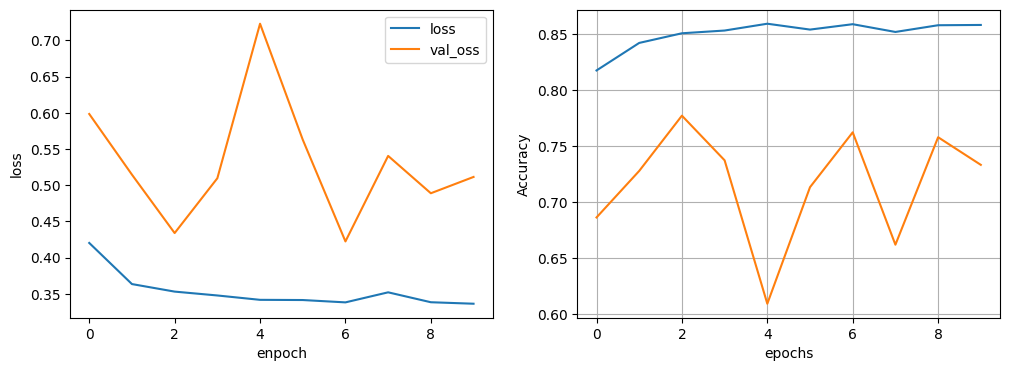

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - accuracy: 0.8511 - loss: 0.3608
nodes: 16 dropout: 0 lr: 0.005 batch size 32


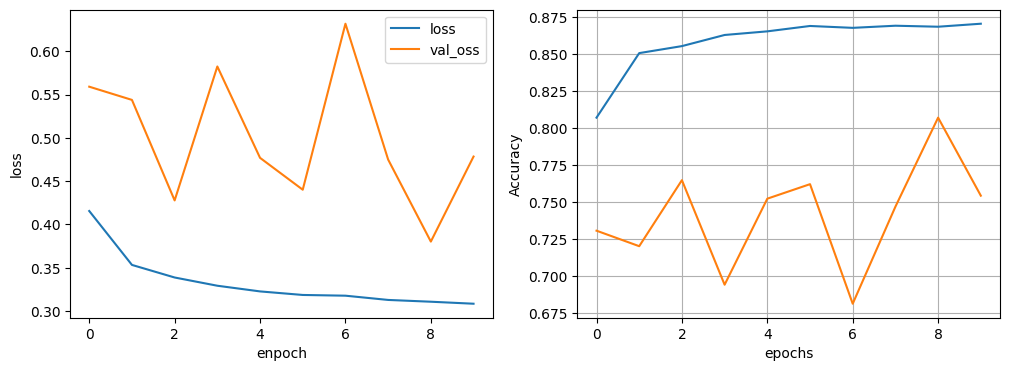

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - accuracy: 0.8575 - loss: 0.3466
nodes: 16 dropout: 0 lr: 0.005 batch size 64


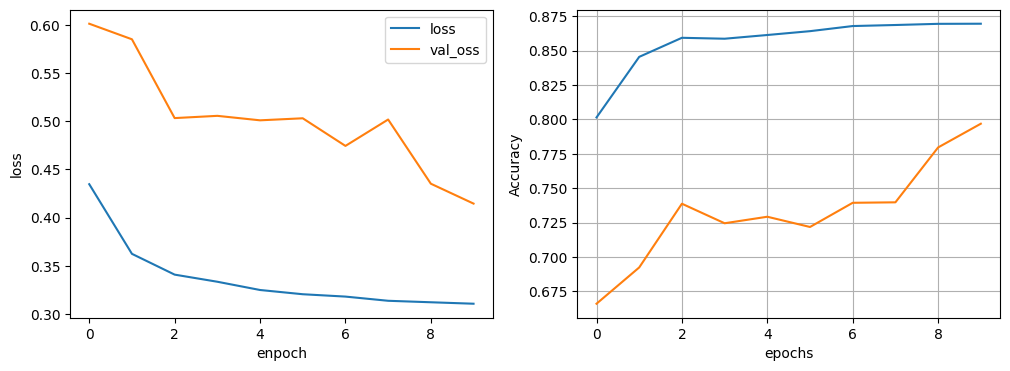

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - accuracy: 0.8452 - loss: 0.3638
nodes: 16 dropout: 0 lr: 0.005 batch size 128


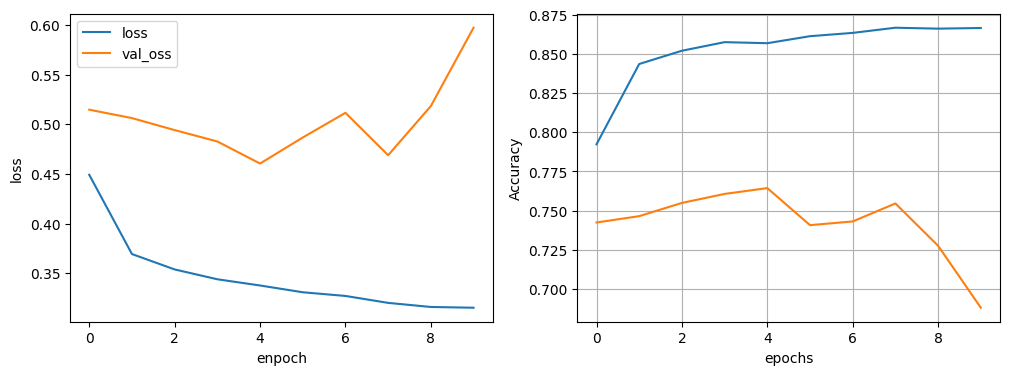

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - accuracy: 0.8688 - loss: 0.3302
nodes: 16 dropout: 0 lr: 0.001 batch size 32


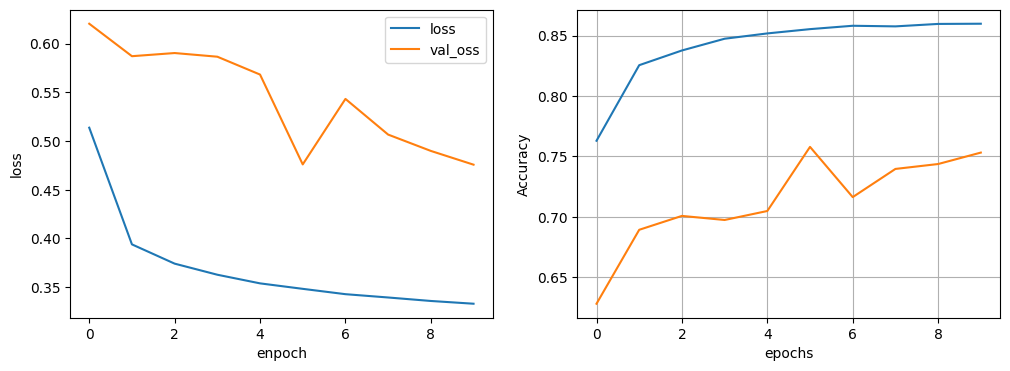

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - accuracy: 0.8506 - loss: 0.3605
nodes: 16 dropout: 0 lr: 0.001 batch size 64


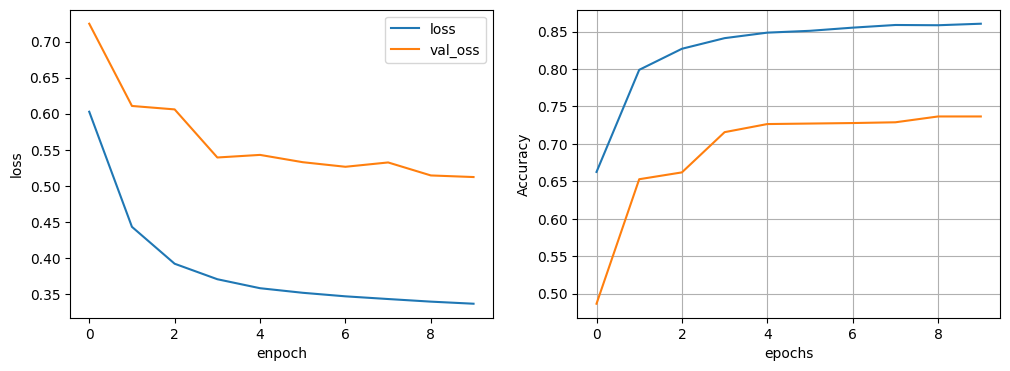

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - accuracy: 0.8503 - loss: 0.3671
nodes: 16 dropout: 0 lr: 0.001 batch size 128


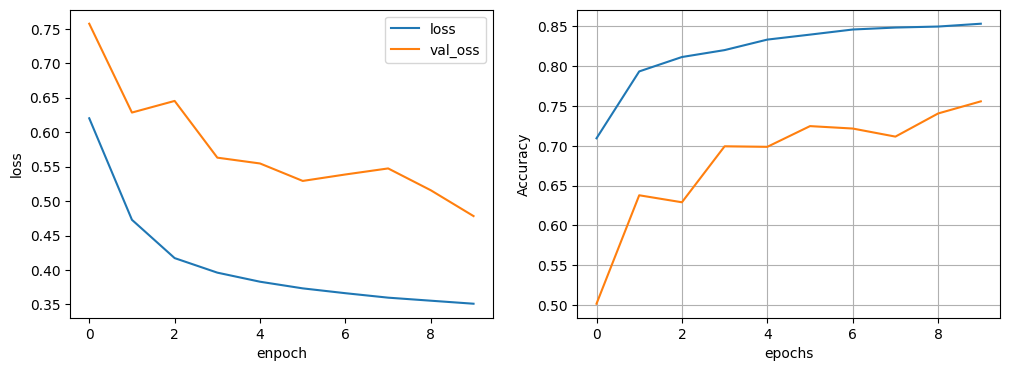

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - accuracy: 0.8316 - loss: 0.3869
nodes: 16 dropout: 0.2 lr: 0.1 batch size 32


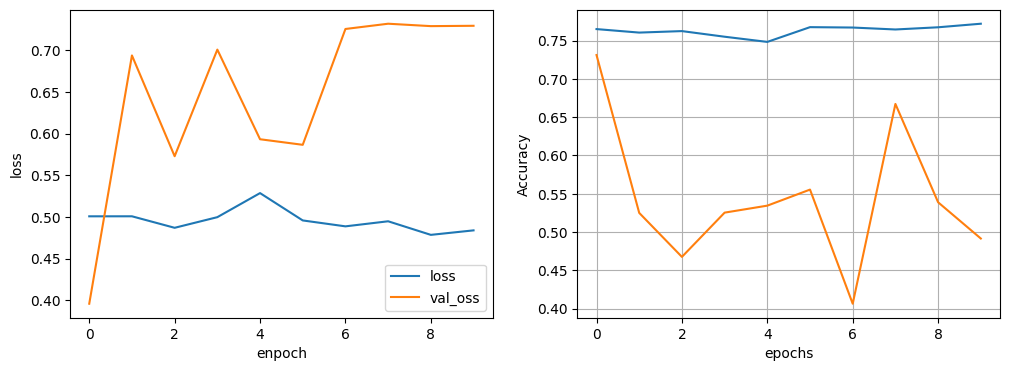

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - accuracy: 0.8220 - loss: 0.4206
nodes: 16 dropout: 0.2 lr: 0.1 batch size 64


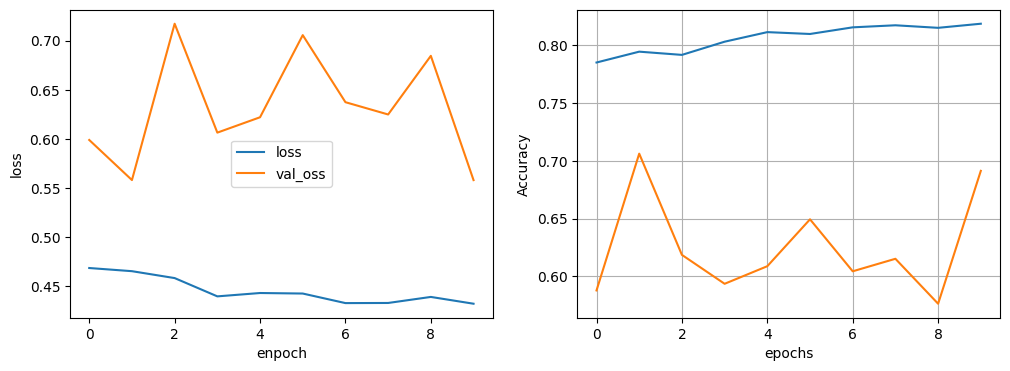

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - accuracy: 0.8395 - loss: 0.3988
nodes: 16 dropout: 0.2 lr: 0.1 batch size 128


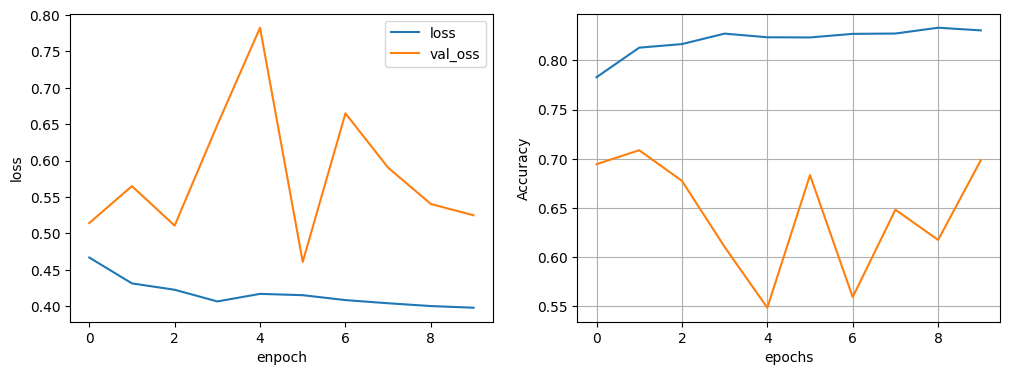

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - accuracy: 0.8520 - loss: 0.3903
nodes: 16 dropout: 0.2 lr: 0.005 batch size 32


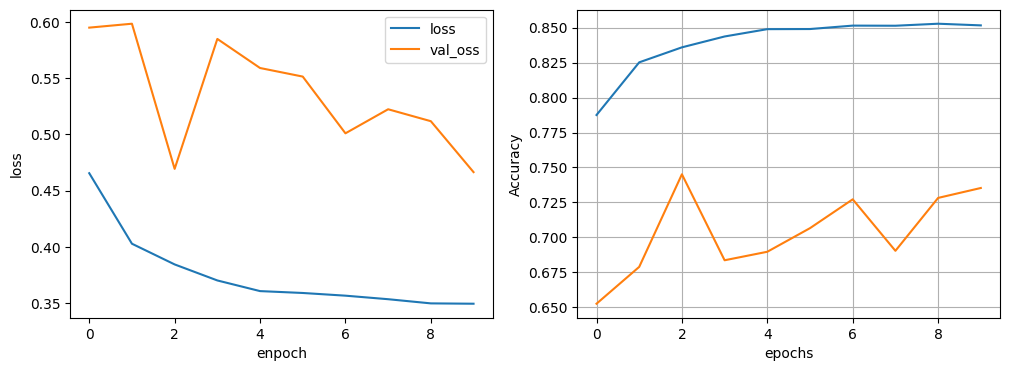

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - accuracy: 0.8554 - loss: 0.3549
nodes: 16 dropout: 0.2 lr: 0.005 batch size 64


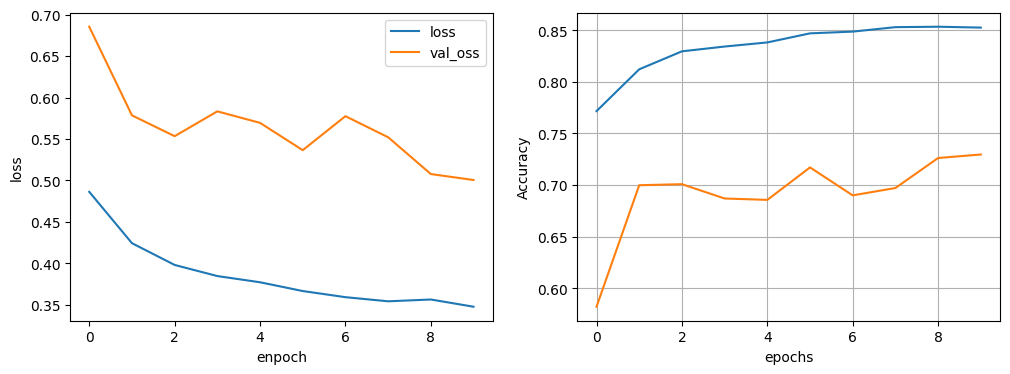

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - accuracy: 0.8575 - loss: 0.3479
nodes: 16 dropout: 0.2 lr: 0.005 batch size 128


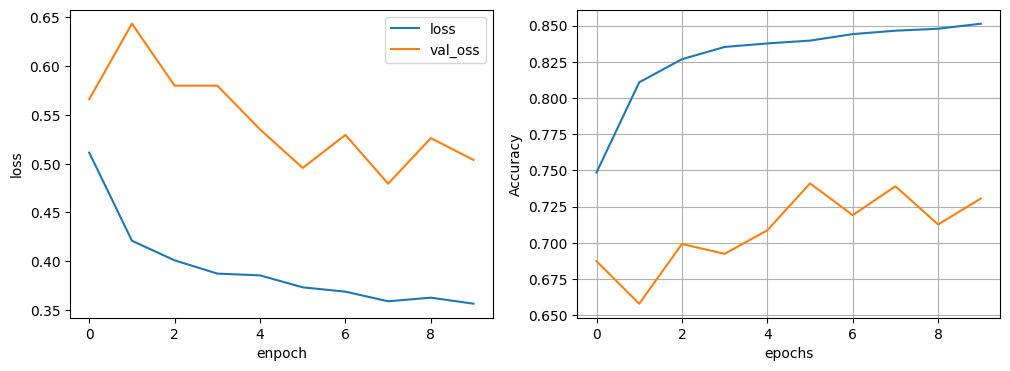

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - accuracy: 0.8535 - loss: 0.3543
nodes: 16 dropout: 0.2 lr: 0.001 batch size 32


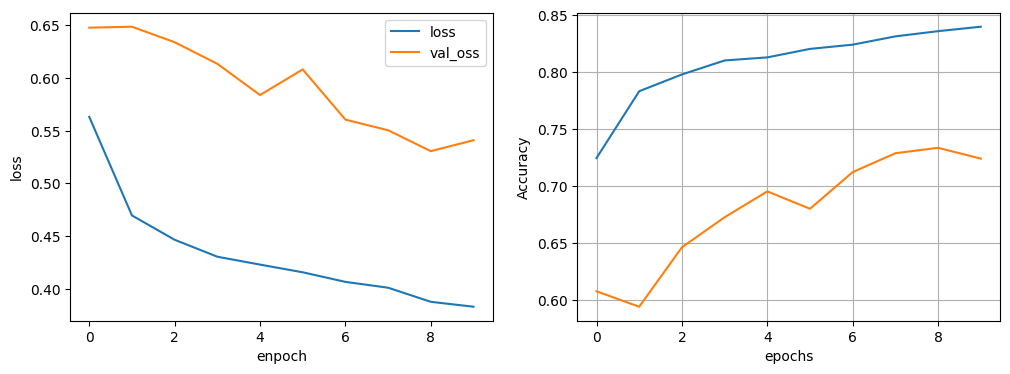

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - accuracy: 0.8474 - loss: 0.3709
nodes: 16 dropout: 0.2 lr: 0.001 batch size 64


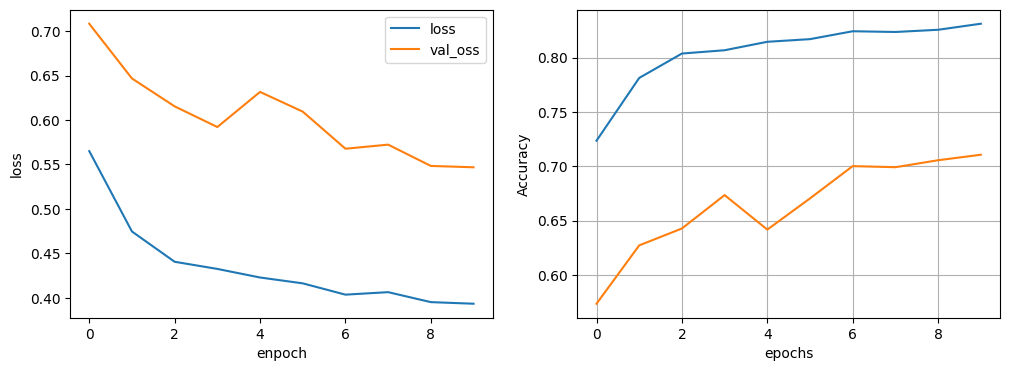

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - accuracy: 0.8462 - loss: 0.3760
nodes: 16 dropout: 0.2 lr: 0.001 batch size 128


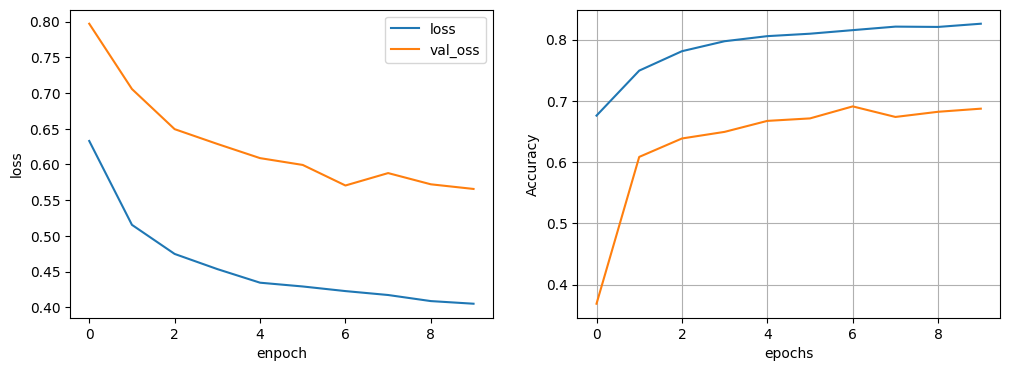

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - accuracy: 0.8435 - loss: 0.3807
nodes: 32 dropout: 0 lr: 0.1 batch size 32


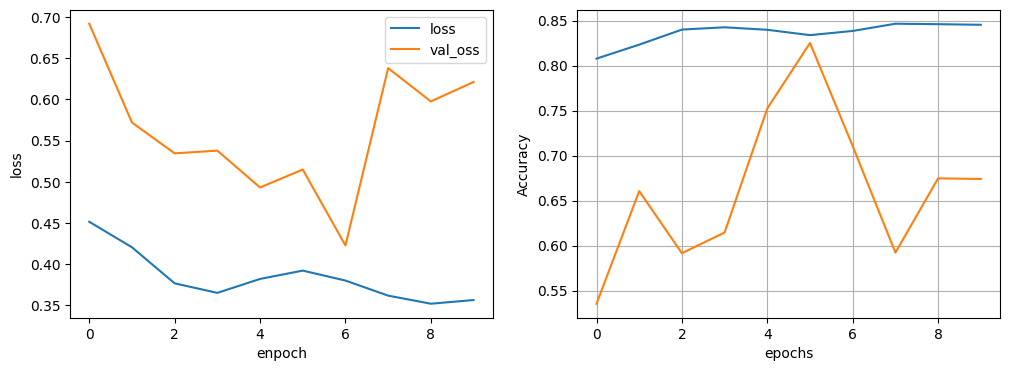

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - accuracy: 0.8553 - loss: 0.3512
nodes: 32 dropout: 0 lr: 0.1 batch size 64


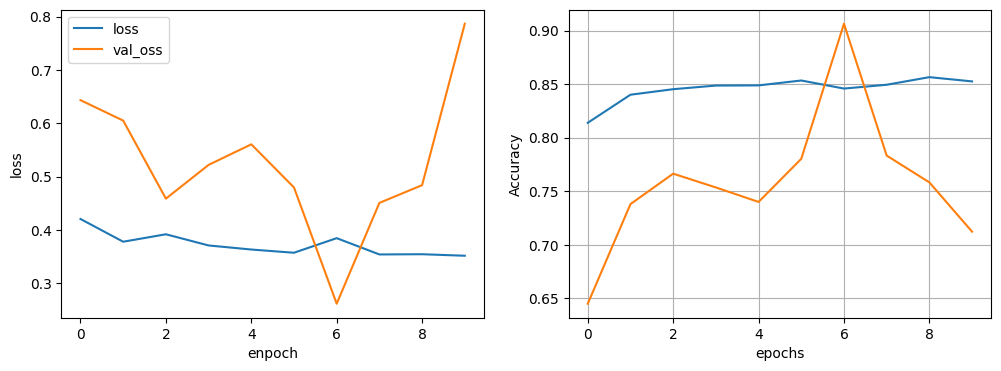

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - accuracy: 0.8565 - loss: 0.3900
nodes: 32 dropout: 0 lr: 0.1 batch size 128


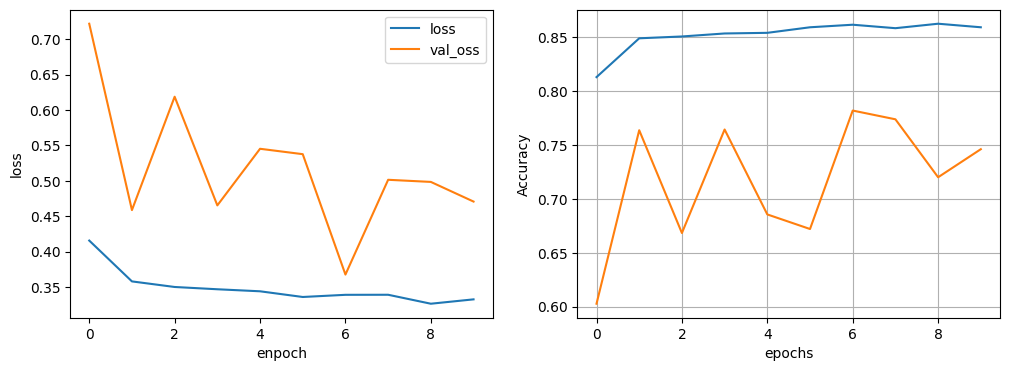

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8479 - loss: 0.3566  
nodes: 32 dropout: 0 lr: 0.005 batch size 32


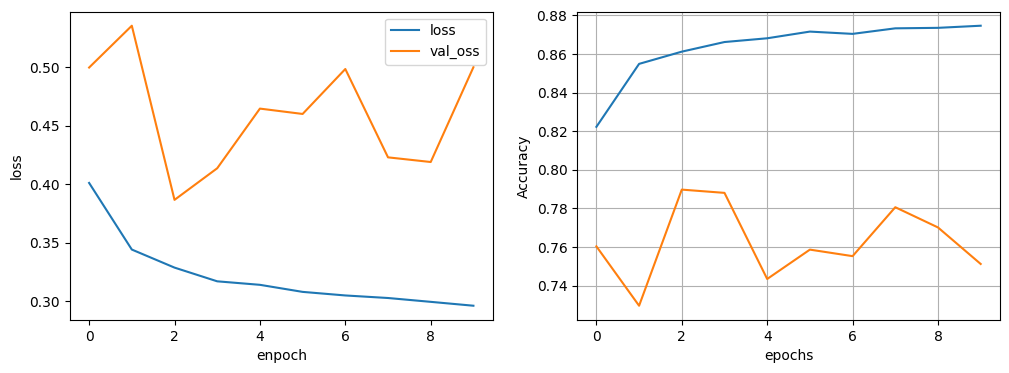

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - accuracy: 0.8658 - loss: 0.3349
nodes: 32 dropout: 0 lr: 0.005 batch size 64


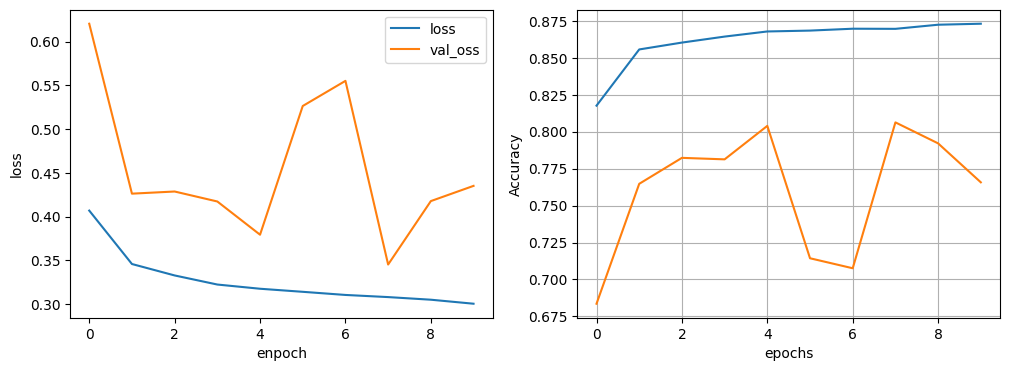

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - accuracy: 0.8489 - loss: 0.3571
nodes: 32 dropout: 0 lr: 0.005 batch size 128


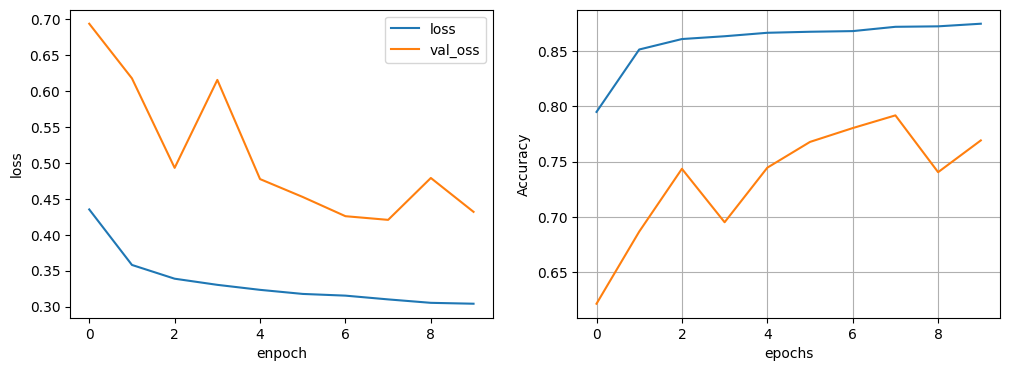

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.8473 - loss: 0.3570
nodes: 32 dropout: 0 lr: 0.001 batch size 32


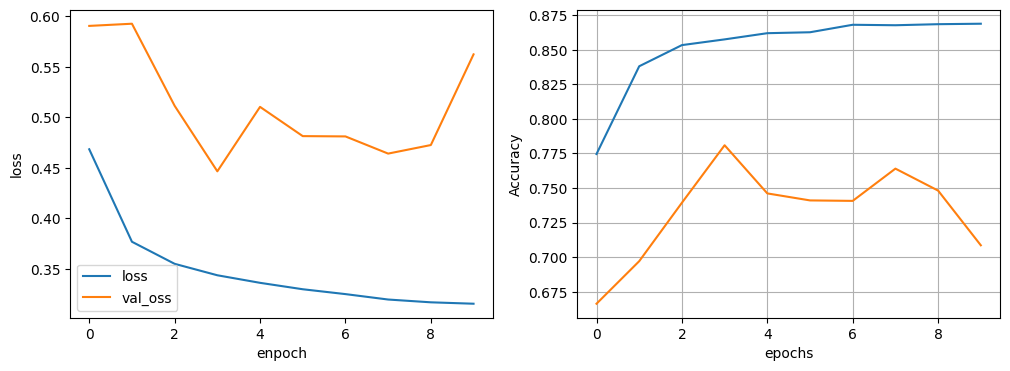

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - accuracy: 0.8540 - loss: 0.3402
nodes: 32 dropout: 0 lr: 0.001 batch size 64


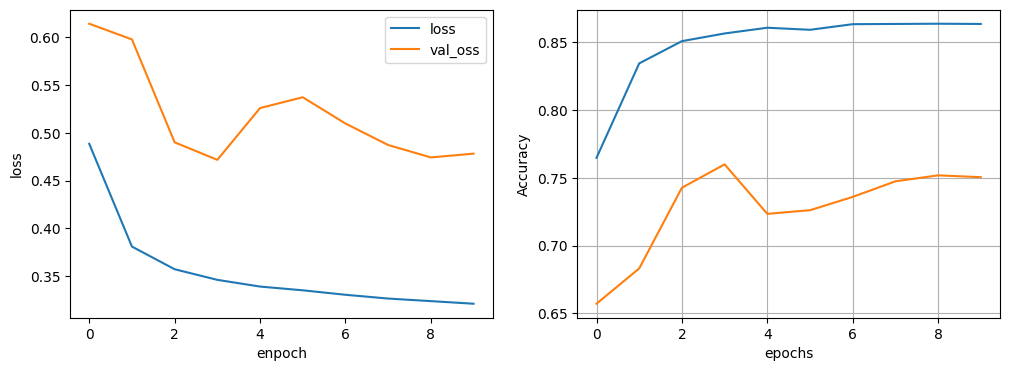

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.8514 - loss: 0.3490
nodes: 32 dropout: 0 lr: 0.001 batch size 128


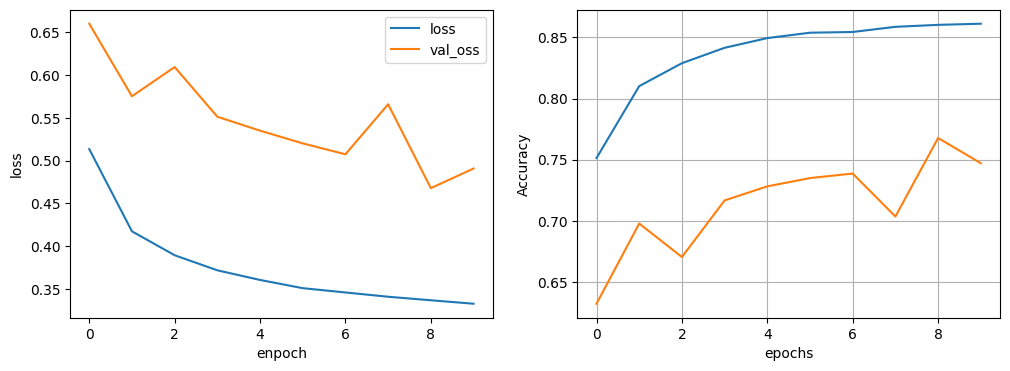

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - accuracy: 0.8526 - loss: 0.3686
nodes: 32 dropout: 0.2 lr: 0.1 batch size 32


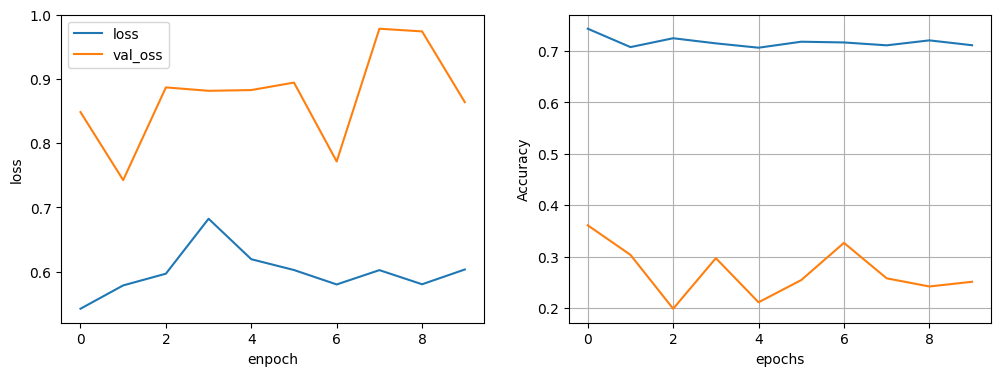

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - accuracy: 0.7370 - loss: 0.5575
nodes: 32 dropout: 0.2 lr: 0.1 batch size 64


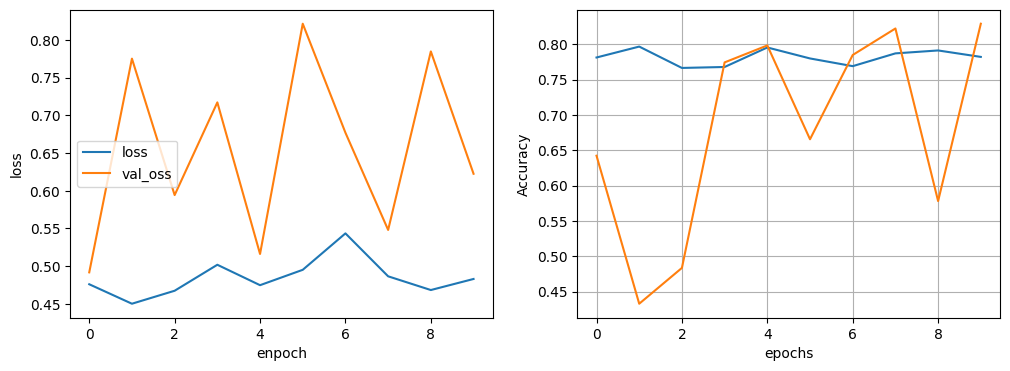

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - accuracy: 0.7949 - loss: 0.4678
nodes: 32 dropout: 0.2 lr: 0.1 batch size 128


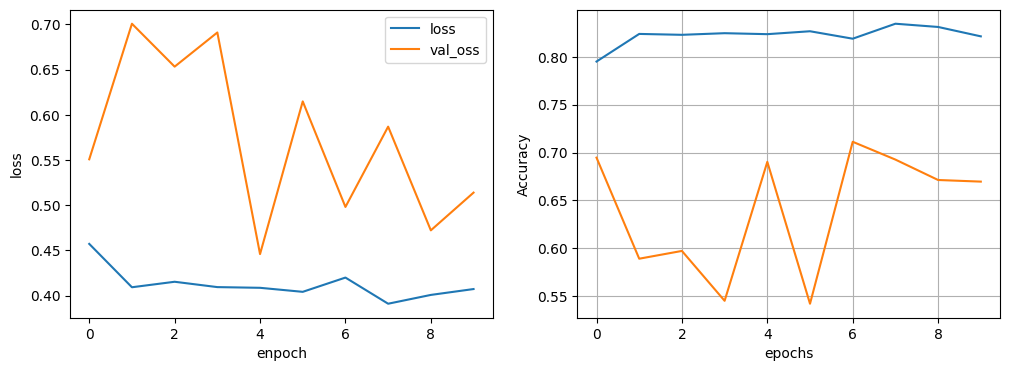

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - accuracy: 0.8557 - loss: 0.3761
nodes: 32 dropout: 0.2 lr: 0.005 batch size 32


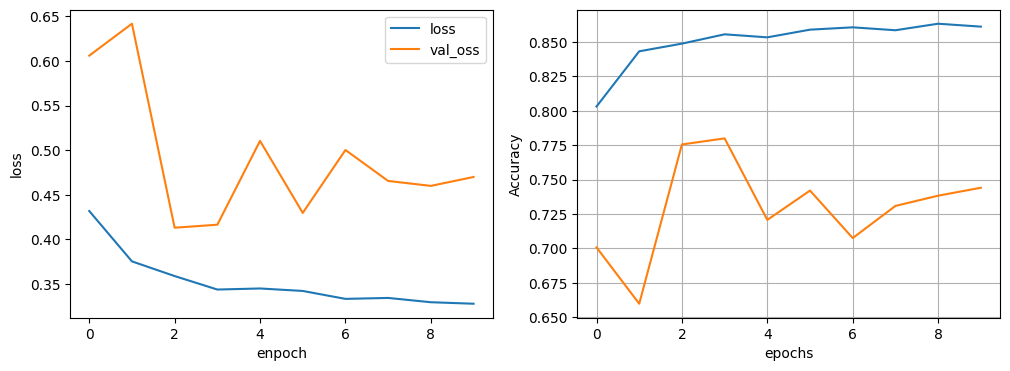

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - accuracy: 0.8530 - loss: 0.3508
nodes: 32 dropout: 0.2 lr: 0.005 batch size 64


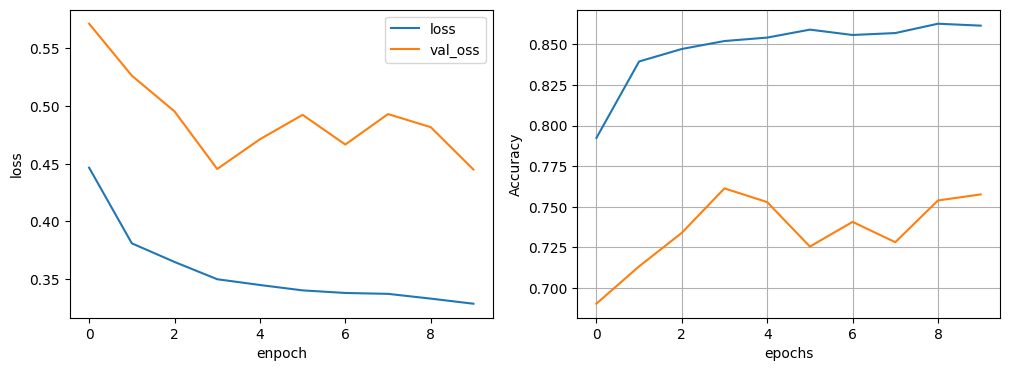

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - accuracy: 0.8559 - loss: 0.3575
nodes: 32 dropout: 0.2 lr: 0.005 batch size 128


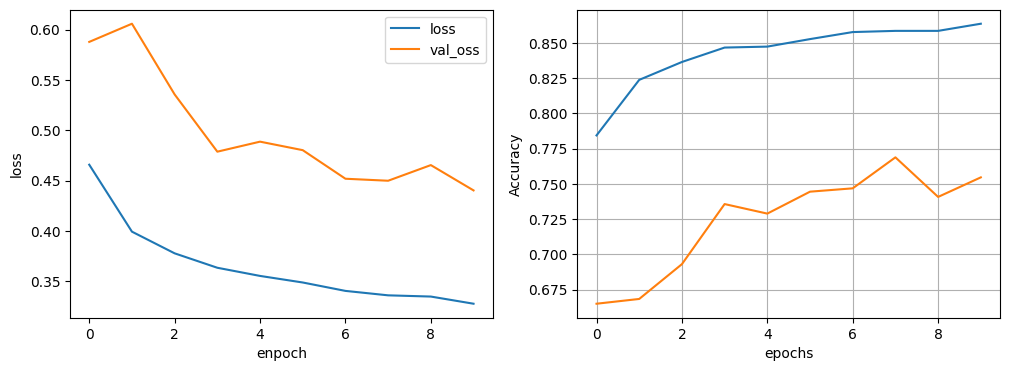

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - accuracy: 0.8524 - loss: 0.3509
nodes: 32 dropout: 0.2 lr: 0.001 batch size 32


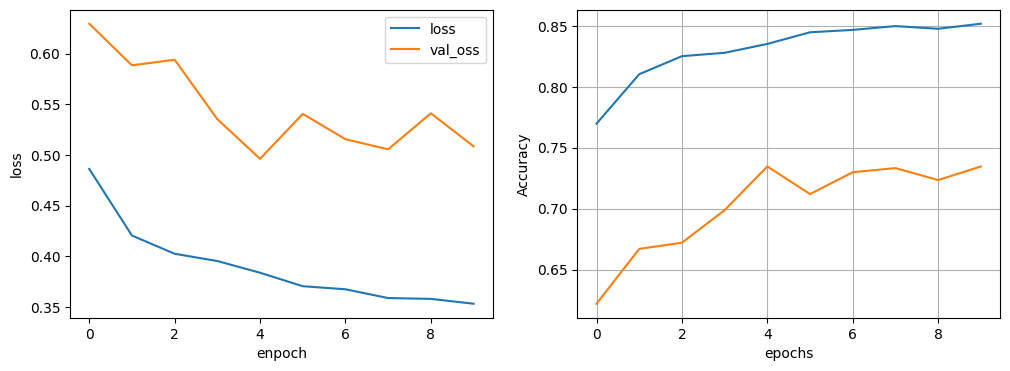

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - accuracy: 0.8547 - loss: 0.3499
nodes: 32 dropout: 0.2 lr: 0.001 batch size 64


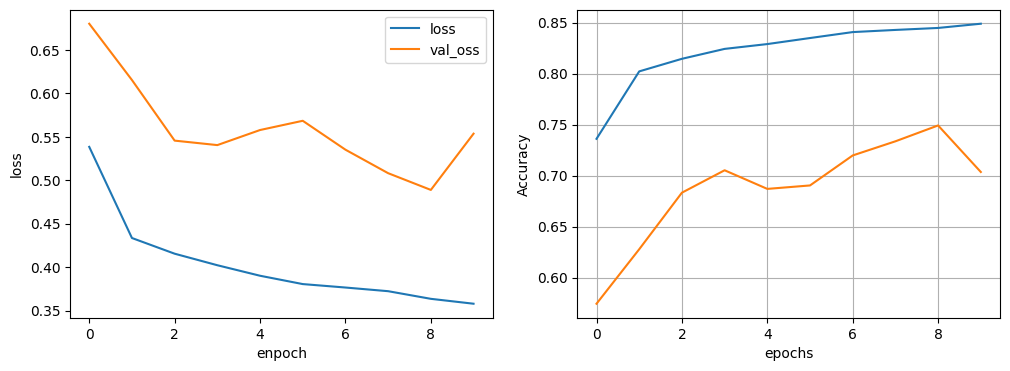

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - accuracy: 0.8586 - loss: 0.3422
nodes: 32 dropout: 0.2 lr: 0.001 batch size 128


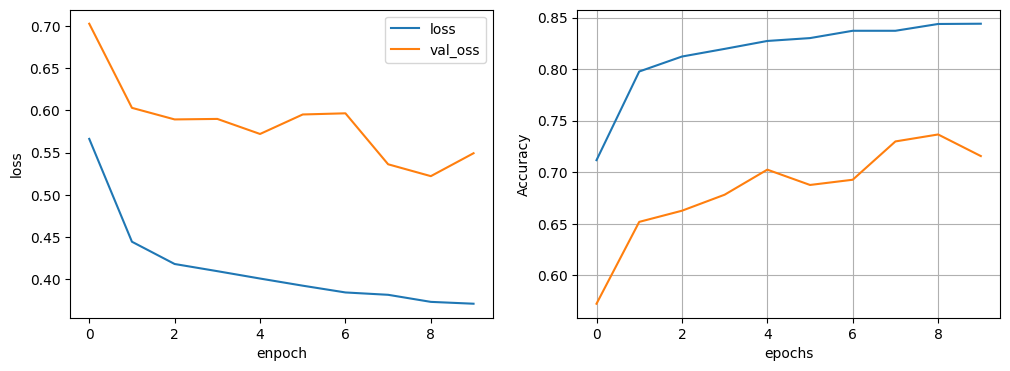

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - accuracy: 0.8504 - loss: 0.3580
nodes: 64 dropout: 0 lr: 0.1 batch size 32


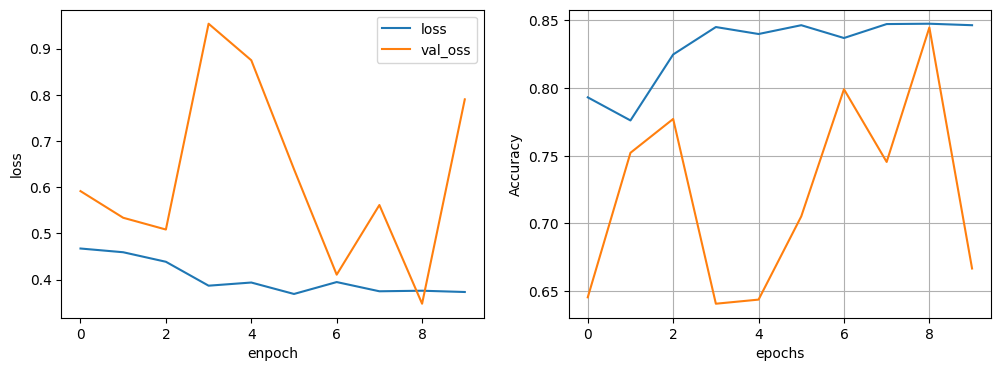

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - accuracy: 0.8487 - loss: 0.3768
nodes: 64 dropout: 0 lr: 0.1 batch size 64


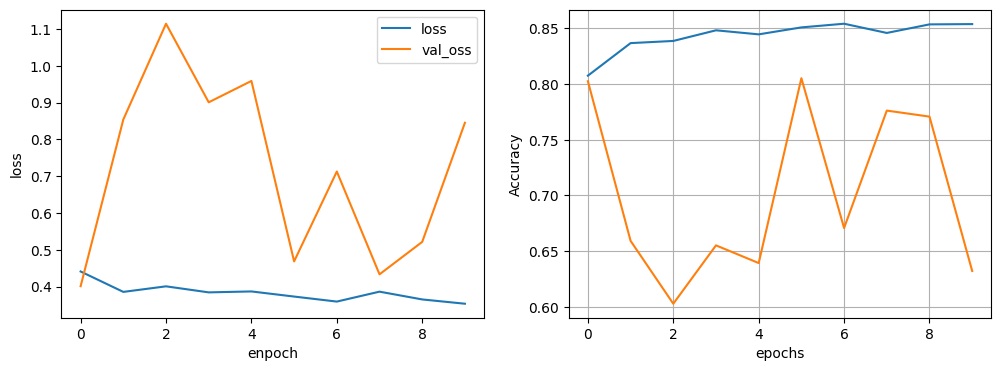

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.8639 - loss: 0.3552
nodes: 64 dropout: 0 lr: 0.1 batch size 128


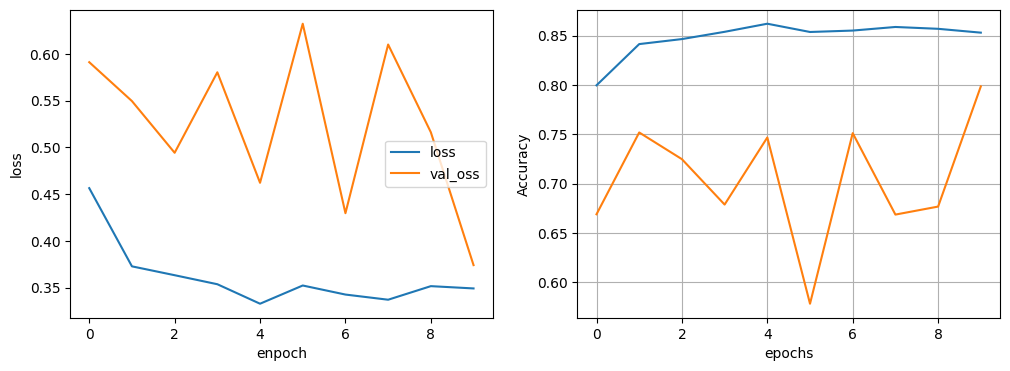

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - accuracy: 0.8320 - loss: 0.4169
nodes: 64 dropout: 0 lr: 0.005 batch size 32


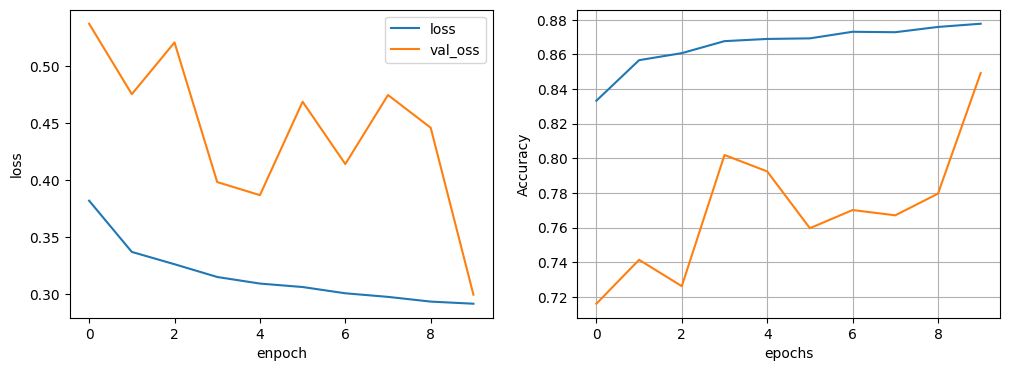

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - accuracy: 0.8212 - loss: 0.4106
nodes: 64 dropout: 0 lr: 0.005 batch size 64


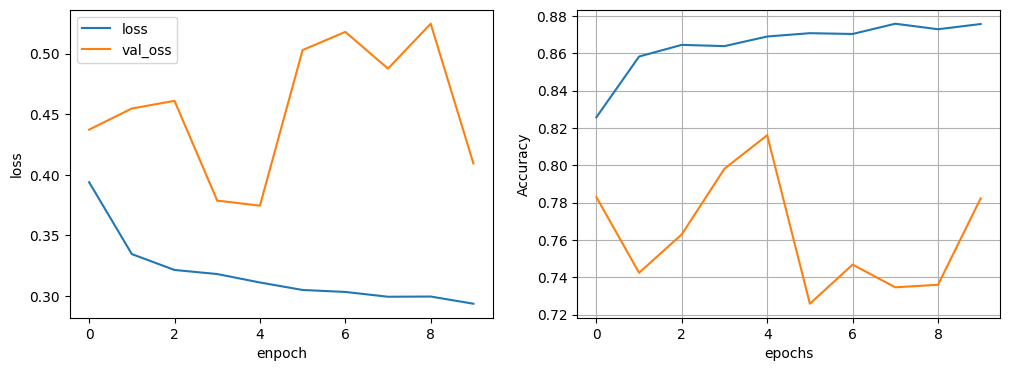

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - accuracy: 0.8533 - loss: 0.3540
nodes: 64 dropout: 0 lr: 0.005 batch size 128


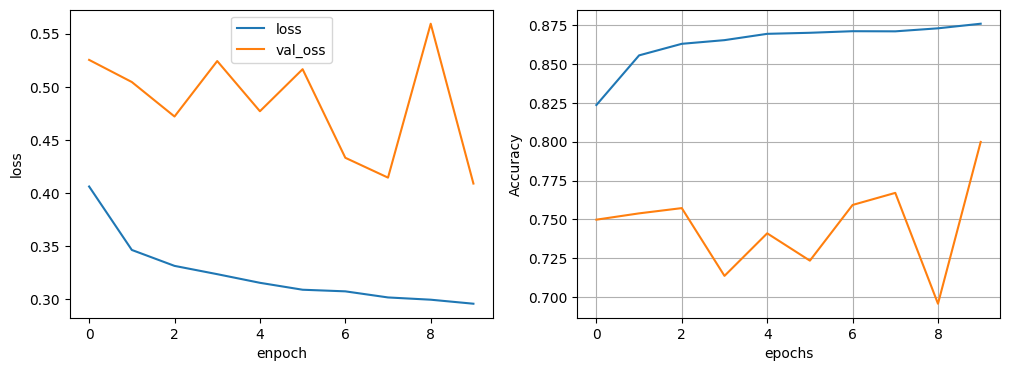

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - accuracy: 0.8488 - loss: 0.3557
nodes: 64 dropout: 0 lr: 0.001 batch size 32


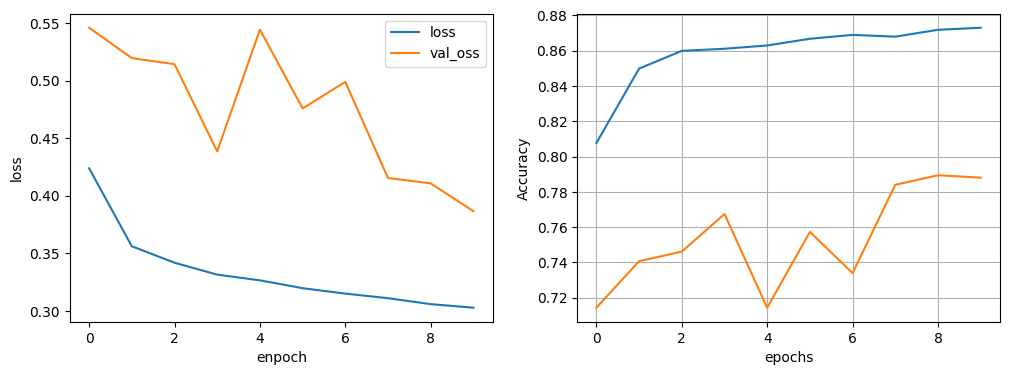

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - accuracy: 0.8460 - loss: 0.3631
nodes: 64 dropout: 0 lr: 0.001 batch size 64


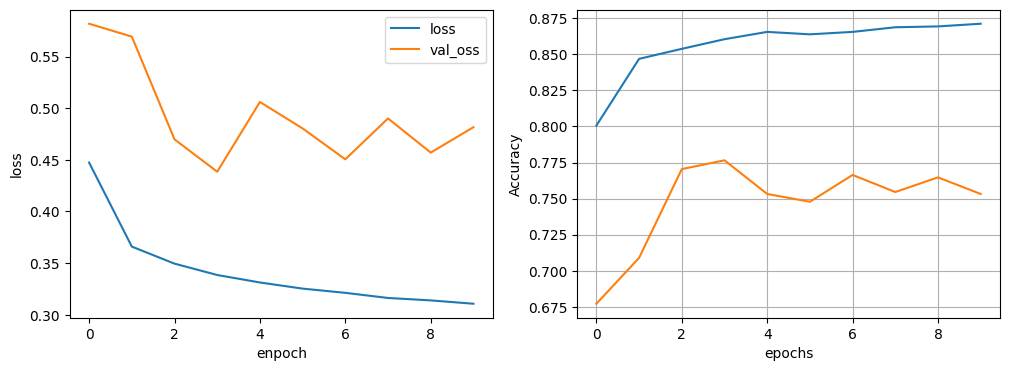

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - accuracy: 0.8569 - loss: 0.3443
nodes: 64 dropout: 0 lr: 0.001 batch size 128


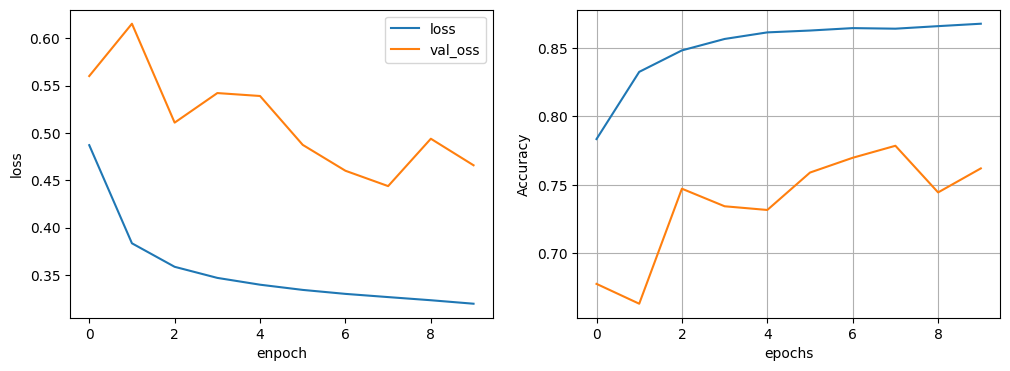

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - accuracy: 0.8529 - loss: 0.3495
nodes: 64 dropout: 0.2 lr: 0.1 batch size 32


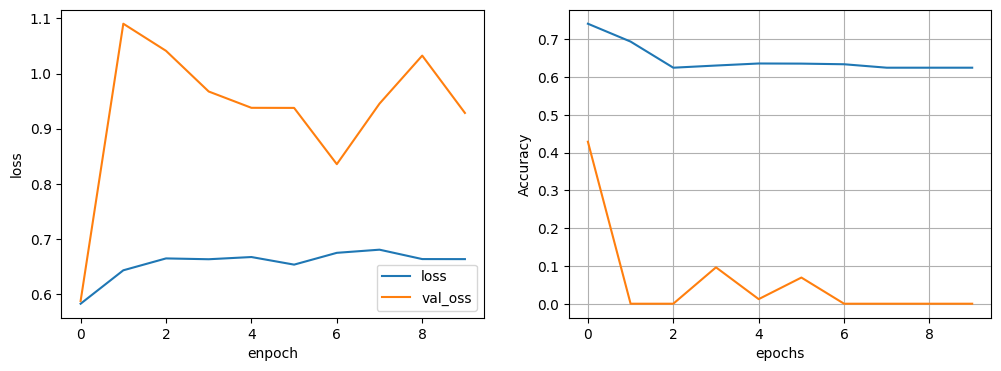

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.6437 - loss: 0.6545
nodes: 64 dropout: 0.2 lr: 0.1 batch size 64


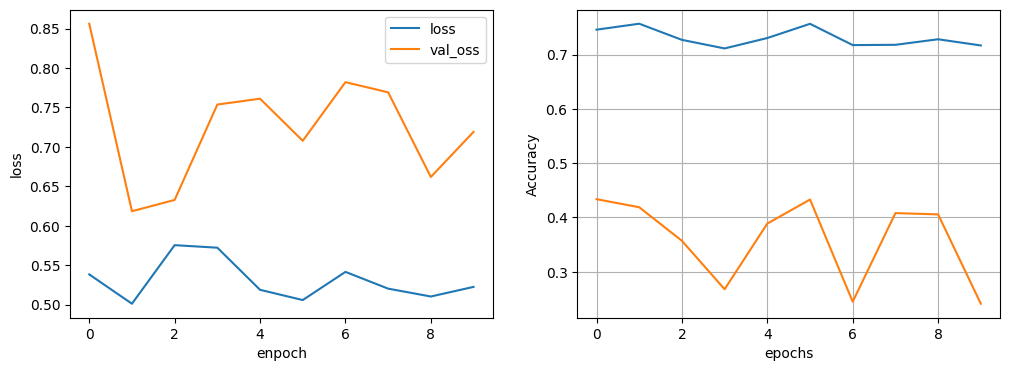

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - accuracy: 0.7275 - loss: 0.4821
nodes: 64 dropout: 0.2 lr: 0.1 batch size 128


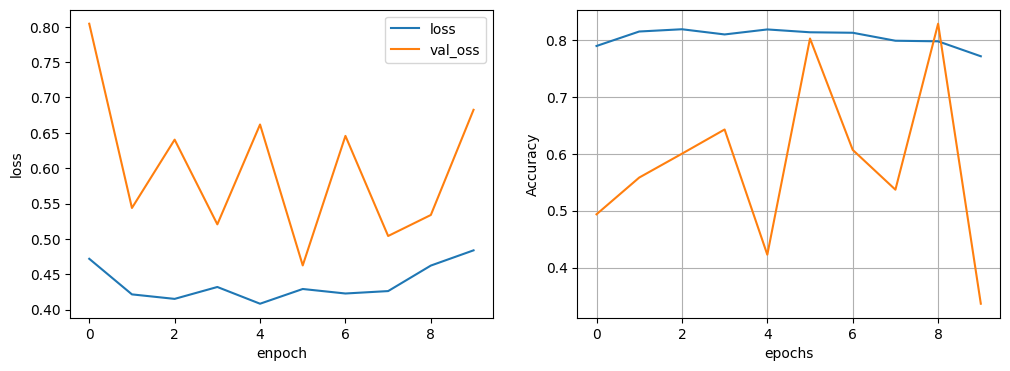

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - accuracy: 0.7499 - loss: 0.5025
nodes: 64 dropout: 0.2 lr: 0.005 batch size 32


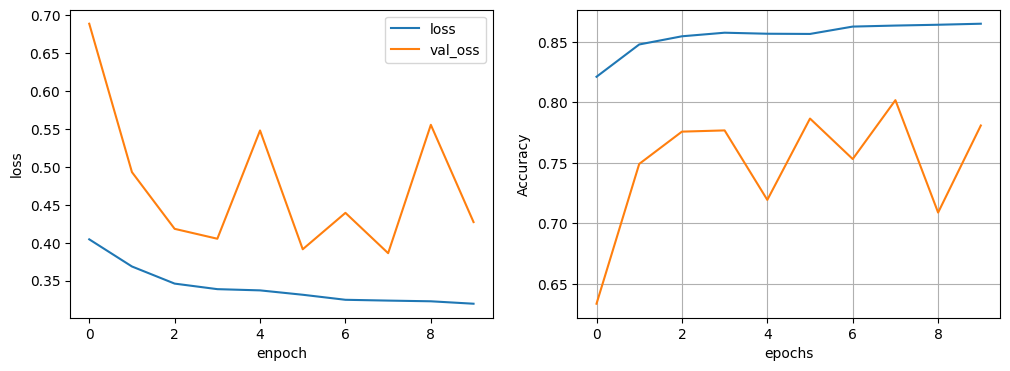

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - accuracy: 0.8506 - loss: 0.3559
nodes: 64 dropout: 0.2 lr: 0.005 batch size 64


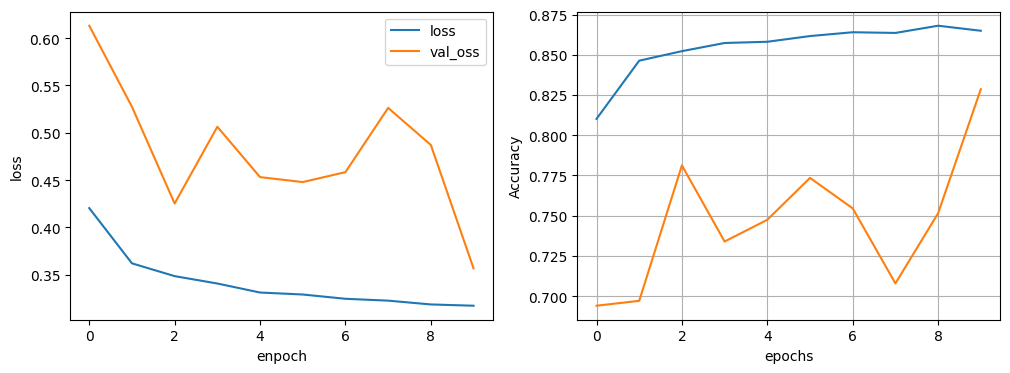

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - accuracy: 0.8327 - loss: 0.3847
nodes: 64 dropout: 0.2 lr: 0.005 batch size 128


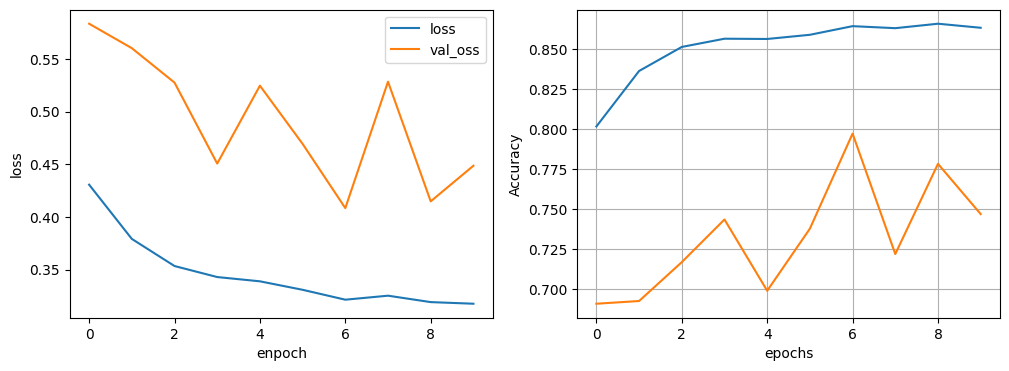

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.8532 - loss: 0.3414
nodes: 64 dropout: 0.2 lr: 0.001 batch size 32


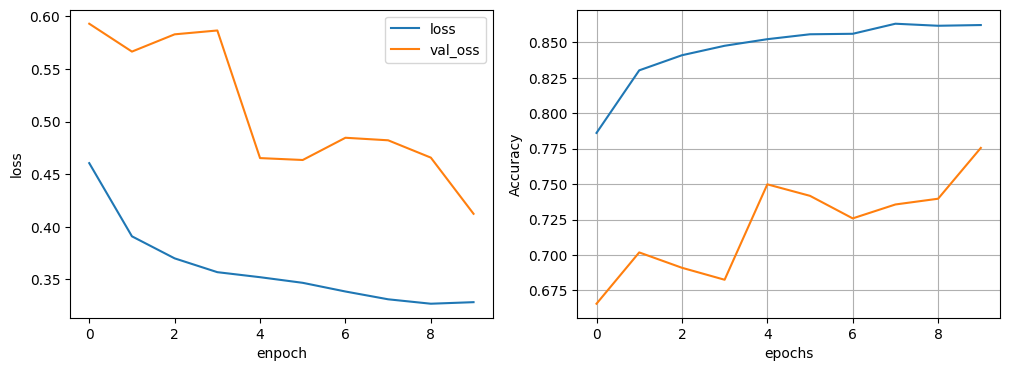

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - accuracy: 0.8515 - loss: 0.3555
nodes: 64 dropout: 0.2 lr: 0.001 batch size 64


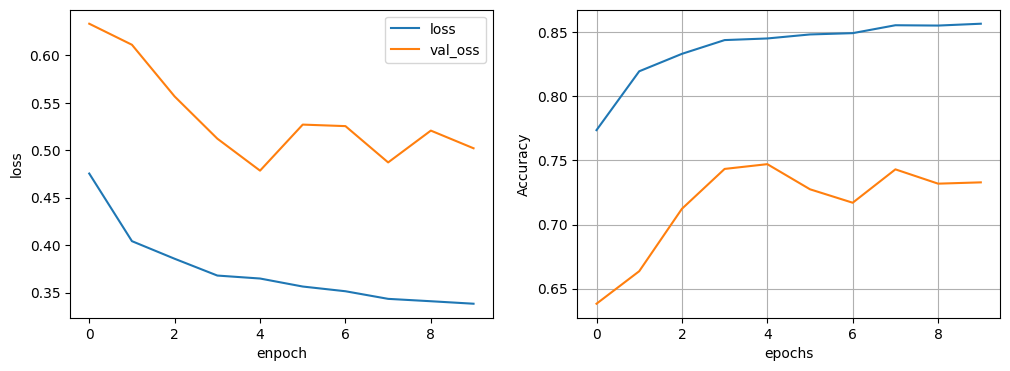

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - accuracy: 0.8555 - loss: 0.3388
nodes: 64 dropout: 0.2 lr: 0.001 batch size 128


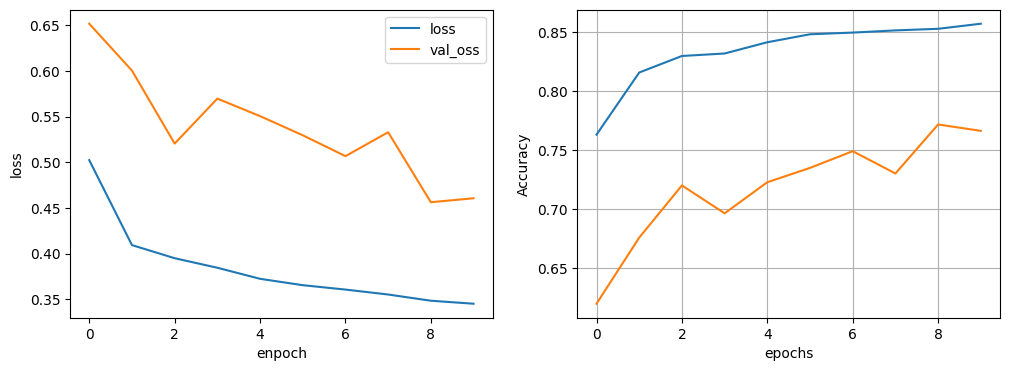

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - accuracy: 0.8523 - loss: 0.3602


In [25]:
least_val_loss = float('inf')
least_loss_model = None


epochs=10

for num_nodes in [16, 32, 64]:
    for dropout_prob in [0, 0.2]:
        for lr in [0.1, 0.005, 0.001]:
            for batch_size in [32, 64, 128]:
                print(f'nodes: {num_nodes} dropout: {dropout_prob} lr: {lr} batch size {batch_size}')
                model, history = train_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs)
                plot_history(history)

                val_loss = model.evaluate(X_valid, y_valid)[0]

                if val_loss < least_val_loss:
                    least_val_loss = val_loss
                    least_loss_model = model

### Accuracy

In [26]:
y_pred = least_loss_model.predict(X_test)
y_pred = (y_pred>0.5).astype(int).reshape(-1,1)

print(classification_report(y_test, y_pred))

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
              precision    recall  f1-score   support

           0       0.84      0.73      0.78      1301
           1       0.87      0.93      0.90      2503

    accuracy                           0.86      3804
   macro avg       0.86      0.83      0.84      3804
weighted avg       0.86      0.86      0.86      3804

